<h1 style='text-align: center;'> B-cell Epitope Immune Response | Rafael Almazan </h1>
<h3 style='text-align: center;'> Machine Learning Models </h3>

## B-cell Epitope Prediction:

Epitope prediction is an important aspect of vaccine development. 

In terms of vaccine development, identifying these regions are crucial. Vaccines are designed to introduce epitopes to the immune system that mimic the real disease, training B-cells to recognize and respond to these epitopic sequences without exposure to the actual disease.

By introducing these epitopic peptides that are similar to the actual disease to the immune system, the vaccines allow the immune system to develop a memory response and the immune system will produce antibodies geared towards fighting the specific disease. Epitopes that will induce an immune response serve as a great base point for vaccine development and this project aims to develop a model that will predict B-cell epitopes based on the protein sequences of a particular disease.

**Note on models:** A standard scaler as well as a 70-15-15 train-validation-test split will be used for our logistic regression models. For consistency, all our models will be split with a random state of 0. We will stratify based on our target column since our target column is imbalanced

**Note on target class:** The target class (antibody_activity) tells us whether or not a peptide is epitopic. A negative result (0) means that it is non-epitopic and a positive result (1) means that the peptide is epitopic. Since our target class is very imbalanced, we are much more interested in the performance of predicting positive results. We want a balance of precision and recall, since we are predicting whether a B-cell will bind to the specific peptide. For this reason, we will be using primarily the f1-score and the recall to evaluate our models, with more emphasis on the f1-score.

In [3]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
# reading in cleaned csv
df = pd.read_csv('bcell_sars_cleaned.csv')
df.head()

,parent_protein_id,protein_seq,start_position,peptide_seq,peptide_length,chou_fasman,emini,kolaskar_tongaonkar,parker,parent_isoelectric_point,parent_aromaticity,parent_hydrophobicity,parent_instability_index,antibody_activity,isoelectric_point,aromaticity,molecular_weight,instability_index,hydrophobicity,charge_at_pH=7.4,amino_acid_ala,amino_acid_arg,amino_acid_asn,amino_acid_asp,amino_acid_cys,amino_acid_gln,amino_acid_glu,amino_acid_gly,amino_acid_his,amino_acid_ile,amino_acid_leu,amino_acid_lys,amino_acid_met,amino_acid_phe,amino_acid_pro,amino_acid_ser,amino_acid_thr,amino_acid_trp,amino_acid_tyr,amino_acid_val
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,SASFT,5,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1,5.240009,0.2,511.5255,8.00,0.46,-0.539854,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,LCLKI,5,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1,8.222249,0.0,588.8033,12.56,2.14,0.749202,0,0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,AHRET,5,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1,6.794385,0.0,612.6361,-8.98,-2.02,-0.114151,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,SNYDD,5,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1,4.050028,0.2,612.5432,55.36,-2.52,-2.535430,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,DGTYR,5,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1,5.835682,0.2,610.6168,-42.80,-2.08,-0.239787,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0


Before we start, we will remind ourselves of the correlations between our features and our target variable to aid us in feature selection

In [5]:
# creating DataFrame of Numeric columns and target variable
X = df.drop(['parent_protein_id', 'protein_seq', 'peptide_seq', 'antibody_activity'], axis=1)
y = df['antibody_activity']

# creating Dataframe as a visual
pearson_results = pd.DataFrame(columns=['statistic', 'pvalue', 'statistically significant'], index=X.columns)


# interating over each column and running a pearsonR test with the column and the target variable
for col in X.columns:
    pearson_corr, pvalue = stats.pearsonr(X[col], y)
    pearson_results.loc[col, 'statistic'] = pearson_corr
    pearson_results.loc[col, 'pvalue'] = pvalue
    pearson_results.loc[col, 'statistically significant'] = (pvalue < 0.05)

# showing dataframe of only statistically significant correlations
display(pearson_results[pearson_results['statistically significant']].sort_values(by='statistic', ascending=False, key=abs))

,statistic,pvalue,statistically significant
parent_isoelectric_point,-0.127073,0.0,True
amino_acid_pro,0.10774,0.0,True
parent_hydrophobicity,0.099975,0.0,True
chou_fasman,0.08618,0.0,True
amino_acid_tyr,0.081399,0.0,True
emini,0.079656,0.0,True
hydrophobicity,-0.071794,0.0,True
start_position,-0.070144,0.0,True
aromaticity,0.063493,0.0,True
amino_acid_arg,0.06085,0.0,True


## Feature Selection

To start, we will select our features based on context and performance on our logistic regression model as a base model. We are selecting features on a logistic regression model since it is a very basic model and will allow us some insight into interpretability of our model and data.

We will use a top-down approach to feature selection, starting with the epitope prediction methods given by IEDB. We will start with these four methods at once due to context. We know that these four are widely used in epitope predictions and they contexually make sense as being able to contribute and predict B-cell epitopes. This will serve as our base model.

Since we have an imbalanced target class, we will also make use of a confusion matrix and a classification report to evaluate our models

We will first take a look at the correlations between these method values, to ensure we do not have multicolinearity in our model. We will use a correlation threshold of 0.7 as an indication of high collinearity

<function matplotlib.pyplot.show(close=None, block=None)>

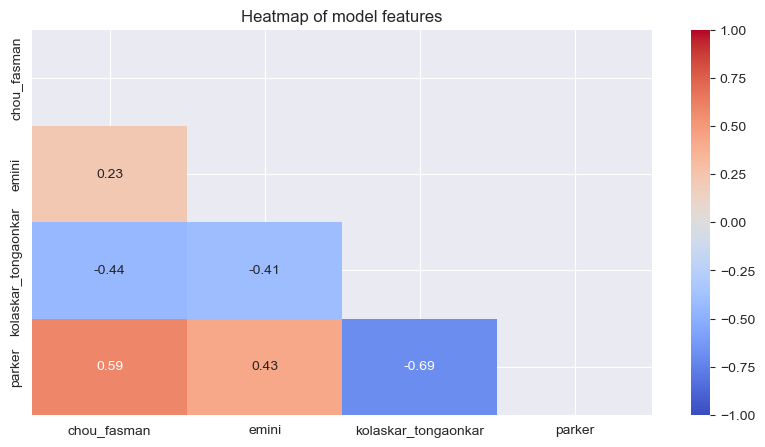

In [6]:
# list of epitope methods from IEDB
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker']

# heatmap of correlations
plt.figure(figsize=(10,5))
sns.heatmap(df[features].corr(), mask=np.triu(df[features].corr()), cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('Heatmap of model features')
plt.show

The heatmap tells us that there is no correlation over 0.7 in our data and therefore we will not remove any features because of multicolinearity. We will go ahead and fit our logistic regressions. 

In [7]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

In [106]:

def print_report(model, X_train, y_train, X_validate, y_validate):
    '''
    print evaluation metrics
    '''
    print(f'{type(model).__name__}:')
    print(f'Training score: {model.score(X_train, y_train).round(3)}')
    print(f'Validation score: {model.score(X_validate, y_validate).round(3)} \n')
    print(f'Confusion Matrix: \n {confusion_matrix(y_validate, model.predict(X_validate))}\n')
    print('Classification report for validation set: \n', classification_report(y_validate, model.predict(X_validate)))

In [9]:
# list of epitope methods from IEDB
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker']

# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)

print_report(logreg, X_train, y_train, X_validate, y_validate)


LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker']
Training score: 0.729
Test score: 0.728
Confusion Matrix: 
 [[1623    7]
 [ 600    5]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1630
           1       0.42      0.01      0.02       605

    accuracy                           0.73      2235
   macro avg       0.57      0.50      0.43      2235
weighted avg       0.65      0.73      0.62      2235



Our base model had decent accuracy on both the train and test sets. However, we must remember that there is an imbalance in our target class and therefore solely going off accuracy will not suffice. Looking at the confusion matrix, we see a great amount of false negatives and our model is only predicting an epitopic peptide 20 times out of 4469 rows in our test set. The model is only able to accurately predict about 1% of the true positives in the test set. Looking at it from this angle, we can tell that our model is fairly poor and we must try to improve it.

Now let's take a look at improving our model by adding more features. 

The original dataset included the parent protein features and we know that the protein features give us the context behind our peptides. We also recall that the parent protein's isoelectric point showed the highest correlation to our target variable and therefore we will try to see if we can increase our accuracy by adding it as a feature along with the other protein characteristics. We have decided to add these features at the same time due to possible interaction effects. Certain protein features may interact with one another and their combined presence or absence may have a different impact on the target variable. We want to utilize this to improve the model's ability to predict outcomes.

In [10]:
# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index']

# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)



LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index']
Training score: 0.733
Test score: 0.73
Confusion Matrix: 
 [[1609   21]
 [ 582   23]]
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1630
           1       0.52      0.04      0.07       605

    accuracy                           0.73      2235
   macro avg       0.63      0.51      0.46      2235
weighted avg       0.68      0.73      0.63      2235



After the addition of the parent protein features, we see an increase in both training and test scores. We are also able to see an increase in the f1-score as well as the precision and recall for epitopic peptides. The model is now predicting about 4% of the true positives in the population and we also see a decreased proportion of its predictions being false positives. 

By considering the parent protein features, we get a deeper understanding of the environment in which the peptides exist and can make more informed predictions. We will keep these features in our final model. However, predicting 4% of the true positives does not equate to a good model by any means and therefore we must do more work to increase our performance

Next, we will see if including the amino acid proline will have an effect on our model since we saw a relationship in our analysis

In [11]:
# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro']

# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)


LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro']
Training score: 0.735
Test score: 0.733
Confusion Matrix: 
 [[1611   19]
 [ 578   27]]
              precision    recall  f1-score   support

           0       0.74      0.99      0.84      1630
           1       0.59      0.04      0.08       605

    accuracy                           0.73      2235
   macro avg       0.66      0.52      0.46      2235
weighted avg       0.70      0.73      0.64      2235



The addition of the amino acid proline as a feature in our model actually slightly improved the model's performance. We see a slight increase in the f1-score as well as an increase in the number of true positives that our model is able to predict. The model is also detects less false positives

This is consistent with our findings that proline dense areas are associated with higher likelihood of a region being epitopic. We will keep this feature for our final model.

Another amino acid feature that made the top five correlations to the target variable would be the amino acid tyrosine. For this reason, we will test it out on our model to see if we are able to increase accuracy.

In [12]:
# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr']
# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)


LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr']
Training score: 0.734
Test score: 0.737
Confusion Matrix: 
 [[1611   19]
 [ 569   36]]
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1630
           1       0.65      0.06      0.11       605

    accuracy                           0.74      2235
   macro avg       0.70      0.52      0.48      2235
weighted avg       0.72      0.74      0.65      2235



Having tyrosine as a feature in our model also slightly improves the test accuracy. This also slightly improves our f1-score, with our model being able to detect more true positives in the unseen test set. For this reason, we will keep the tyrosine feature in our final model.

One more feature that we may want to add would be the start position of the peptide. This gives the model information and context on the position of the sequence within the larger protein sequence. This may give insight on epitope positionality.

In [13]:
# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr', 'start_position']
# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)


LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position']
Training score: 0.734
Test score: 0.746
Confusion Matrix: 
 [[1611   19]
 [ 549   56]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1630
           1       0.75      0.09      0.16       605

    accuracy                           0.75      2235
   macro avg       0.75      0.54      0.51      2235
weighted avg       0.75      0.75      0.66      2235



Interesting! Including the position of our peptide in the model slightly improved performance on the test set. The model is predicting about 9% of the true positives in the population and shows a higher f1-score. 

We may also want to look into adding the hydrophobicity and aromaticity of each peptide sequence since this may give us insight into the specific peptide areas where epitopes can arise from.

In [14]:
# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr', 'start_position', 'hydrophobicity', 'aromaticity']
# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)


LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'hydrophobicity' 'aromaticity']
Training score: 0.737
Test score: 0.748
Confusion Matrix: 
 [[1611   19]
 [ 544   61]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1630
           1       0.76      0.10      0.18       605

    accuracy                           0.75      2235
   macro avg       0.76      0.54      0.51      2235
weighted avg       0.75      0.75      0.67      2235



Including both the peptide's hydrphobicity and aromaticity increases our recall on the validation set by one percent and f1-score by 0.02. This slightly improves our model and we will include these features in our final features to run through our different models.

This will be the final set of features for our models moving forward. The model is complex enough and adding more features will just increase complexity even further. This tradeoff is not justifiable and we must be wary of the interpretability of our model.

### Checking for Multicolinearity

Even if our accuracies do not give us signs of overfitting, we must still be aware that it is a possibility. To account for this, we will check for multicolinearity in our model by taking a look at the correlations between our features.

<function matplotlib.pyplot.show(close=None, block=None)>

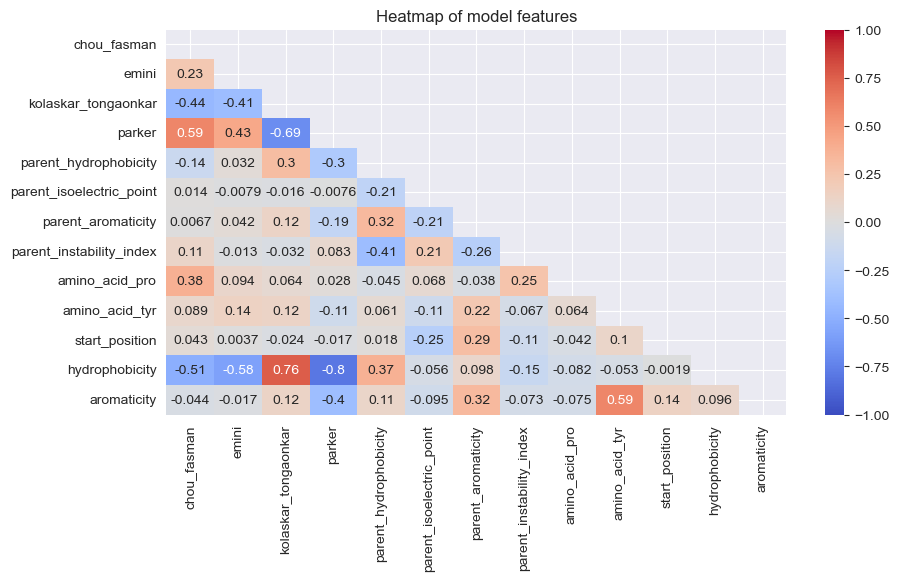

In [15]:
# heatmap of correlations
plt.figure(figsize=(10,5))
sns.heatmap(df[features].corr(), mask=np.triu(df[features].corr()), cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('Heatmap of model features')
plt.show

The heatmap above shows us that our hydrophobicity feature is actually very highly correlated with many of our other features and therefore, we will remove the hydrophobicity feature from our data. This makes sense that it is very well correlated with the parker feature since if we recall, the parker method tells us how hydrophillic a molecule is, the direct opposite of hydrophobicity.

We have no other correlations above 0.7 within our features. This gives us the confidence that there is little to no multicolinearity in the rest of our features and thus we are able to minimize overfitting.

## Modeling

Now that we have our final features, we are able to properly fit our final logistic regression model, and start tuning with hyperparameters

We will split and scale our data here to prepare it for the modeling down below.

In [16]:
# Listing our final features to use for all models from now on.

# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr', 'start_position', 'aromaticity']
# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

## Logistic Regression

To start, we will fit our data to a base logistic regression model. This base model will help us establish a baseline performance and will give us a reference point that we can improve upon. A logistic regression model is also simple and interpretable, allowing us to gain more insight on the features of our model before moving on to more complex models.

In [17]:
# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)

LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.735
Test score: 0.747
Confusion Matrix: 
 [[1613   17]
 [ 548   57]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1630
           1       0.77      0.09      0.17       605

    accuracy                           0.75      2235
   macro avg       0.76      0.54      0.51      2235
weighted avg       0.75      0.75      0.67      2235



Now that we have our features, we can focus on tweaking our hyperparameters and seeing if introducing regularization will affect the model's performance. Seeing that there is no overfitting in our logistic regression model, we do not expect regularization to have much effect in improving our model.

In [18]:
scores = pd.DataFrame()
c_range = [10 ** exp for exp in range(-5, 5 + 1, 1)]

for n,i in enumerate(c_range):
    logreg = LogisticRegression(C=i, penalty='l2', solver='lbfgs')
    logreg.fit(X_train, y_train)
    class_report_train = classification_report(y_train, logreg.predict(X_train), output_dict=True)
    class_report_val = classification_report(y_validate, logreg.predict(X_validate), output_dict=True)

    # appending values and metrics to our scores table
    scores.loc[n,'C-value'] = i
    scores.loc[n,'Training f1 (1)'] = class_report_train['1']['f1-score'] 
    scores.loc[n,'Validation f1 (1)'] = class_report_val['1']['f1-score'] 
scores


,C-value,Training f1 (1),Validation f1 (1)
0,0.00001,0.000000,0.000000
1,0.00010,0.001416,0.003300
2,0.00100,0.028393,0.029079
3,0.01000,0.094648,0.132730
4,0.10000,0.107672,0.159763
5,1.00000,0.111825,0.167894
6,10.00000,0.111825,0.167894
7,100.00000,0.111825,0.167894
8,1000.00000,0.111825,0.167894
9,10000.00000,0.111825,0.167894


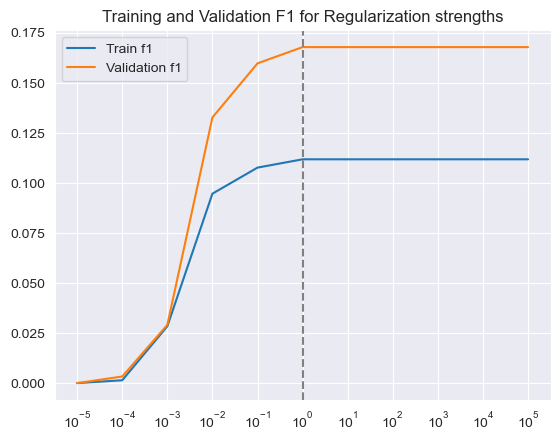

In [19]:
# creating visual to compare train and validation accuracies across different regularization strengths
plt.figure()
plt.plot(scores['C-value'], scores['Training f1 (1)'], label='Train f1')
plt.plot(scores['C-value'], scores['Validation f1 (1)'], label='Validation f1')
plt.title('Training and Validation F1 for Regularization strengths')
plt.xlabel
plt.legend()
plt.xscale('log')
plt.axvline(x=10e-1, linestyle='--', c='grey')
plt.xticks(c_range)
plt.show()

In the graph above, we see no need for regularization since a C-value of 1 will end up giving the best performance for our model for both the train and validation set. We can trust that this will be the best for the given dataset and we do not see any overfitting in our data.

### Odds Ratio

We will now examine the Odds Ratios of our features to determine how each feature in our model affects the odds of seeing an epitopic peptide

In [20]:
# creating a dataframe that shows us both the coefficient and the odds ratio
logreg_odds = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
logreg_odds['Odds ratio'] = np.exp(logreg_odds['Coefficient'])
display(logreg_odds)

,Feature,Coefficient,Odds ratio
0,chou_fasman,0.052657,1.054068
1,emini,0.054666,1.056188
2,kolaskar_tongaonkar,-0.119877,0.887029
3,parker,0.036137,1.036798
4,parent_hydrophobicity,0.275531,1.317229
5,parent_isoelectric_point,-0.350084,0.704629
6,parent_aromaticity,0.038968,1.039737
7,parent_instability_index,0.180950,1.198355
8,amino_acid_pro,0.209045,1.232501
9,amino_acid_tyr,0.082398,1.085888


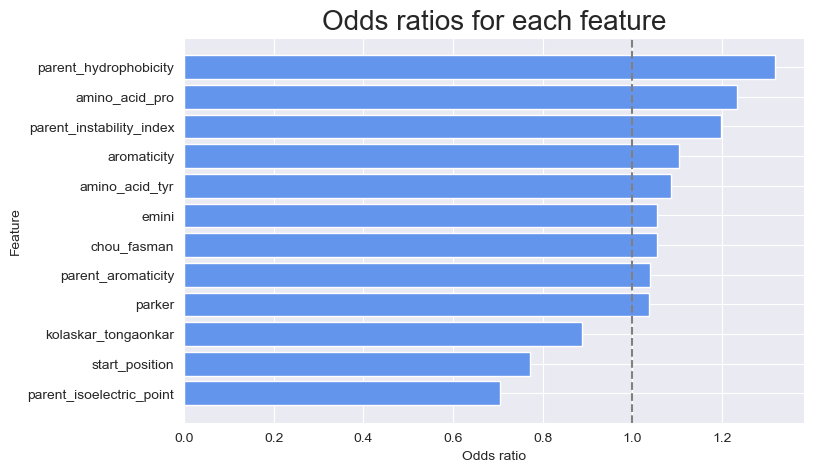

In [21]:
# plotting the odds ratios for each feature
plt.figure(figsize=(8,5))
logreg_odds.sort_values(by='Odds ratio', inplace=True)
plt.barh(logreg_odds['Feature'], logreg_odds['Odds ratio'], color='cornflowerblue')
plt.title('Odds ratios for each feature', fontsize=20)
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.axvline(x=1, linestyle='--', color='gray')
plt.show()

The odds ratio is a measure that informs us on the impact each feature in our model has on the likelihood of seeing an epitopic peptide. These are all specific to this exact model and would change if we altered the model in any way. Having an odds ratio that is greater than 1 suggests a positive effect on the target variable, meaning an increase in that feature would increase the likelihood of seeing an epitopic peptide. Similarly, an odds ratio less than 1 suggests a negative effect. For example, in our model, for each proline molecule present in the peptide, the likelihood of the peptide being epitopic would increase by a factor of 1.2, while an increase in one unit of the parent isoelectric point wouldse the likelihood of seeing an epitope by 0.7, or alternatively, increase the odds of a non-epitopic site by a factor of 1.43.

### Feature Reduction

Since we have 12 different features in our model, the complexity of our model may make things slightly computationally heavy. To deal with this, we will try to conduct PCA analysis on our features to reduce the computational power needed to run our model, without compromising features or accuracy.

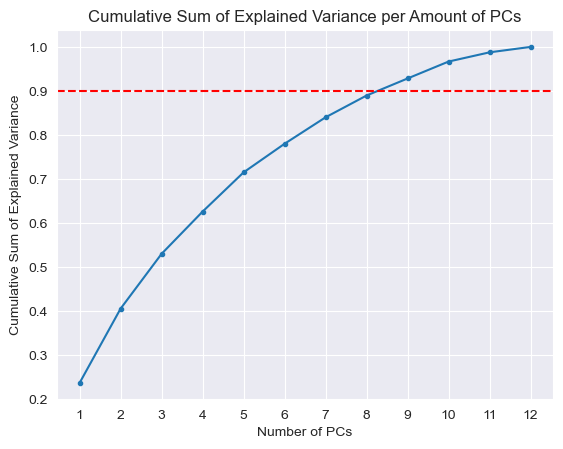

In [22]:
# importing PCA
from sklearn.decomposition import PCA

# fitting PCA to train set with 11 components since we have 11 features
pca = PCA(n_components=12).fit(X_train)
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)

# plot graph of cumulative sum
plt.figure()
plt.plot(range(1,13), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Cumulative Sum of Explained Variance per Amount of PCs')
plt.xticks(range(1,13))
plt.show()

Looking at the graph above, we see that with 8 Principal Components, we are able to explain just over 90% of the variance, thus we will use a Principal component number of 8 to reduce computing power.

In [23]:
# recreate PCA object with 8 components and transform independent variables
pca = PCA(n_components=8).fit(X_train)
X_train_pca = pca.transform(X_train)
X_validate_pca = pca.transform(X_validate)

# fit a logistic regression model
logreg = LogisticRegression().fit(X_train_pca, y_train)
print(f'Logistic Regression with features: {X.columns.values}')
print('Features undergone PCA analysis with 8 principal components')
print(f'Training score: {logreg.score(X_train_pca, y_train).round(3)}')
print(f'Test score: {logreg.score(X_validate_pca, y_validate).round(3)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_validate, logreg.predict(X_validate_pca))}')
print(classification_report(y_validate, logreg.predict(X_validate_pca)))


Logistic Regression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Features undergone PCA analysis with 8 principal components
Training score: 0.733
Test score: 0.74
Confusion Matrix: 
 [[1610   20]
 [ 561   44]]
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1630
           1       0.69      0.07      0.13       605

    accuracy                           0.74      2235
   macro avg       0.71      0.53      0.49      2235
weighted avg       0.73      0.74      0.65      2235



After undergoing PCA analysis, we see that the performance decreases and we are unable to recall as much of the epitopic class as we were able to before PCA analysis. This is understandable since we lose information on about 10% of the variance of our training set. For this reason and due to the importance of our epitopic class predictability, We will not use PCA analysis in our final logistic regression model. reducing our features from 12 to 8 is not a large enough reason to sacrifice our already small ability to predict the epitopic class.

We will run through our final model one more time down below witho our final features, without PCA. We will scale and use this 70-15-15 train, validation and test split for the remainder of the modeling phase.

In [24]:
# list of features for model
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr', 'start_position', 'aromaticity']
# seperating data into an X and y
X = df[features]
y = df['antibody_activity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# test-validation split 50-50
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.50, random_state=0, stratify=y_test)

# combining the train and validate before scaling
X_combined = pd.concat([X_train, X_validate])
y_combined = pd.concat([y_train, y_validate])

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

*We have separated our final train, validation, and test sets. We will not evaluate our models on the test set until the very end of this notebook.*

In [25]:
# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
print_report(logreg, X_train, y_train, X_validate, y_validate)

LogisticRegression with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.735
Test score: 0.747
Confusion Matrix: 
 [[1613   17]
 [ 548   57]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1630
           1       0.77      0.09      0.17       605

    accuracy                           0.75      2235
   macro avg       0.76      0.54      0.51      2235
weighted avg       0.75      0.75      0.67      2235



Text(0.5, 1.0, 'ROC Curve for Epitope Prediction (Logistic Regression)')

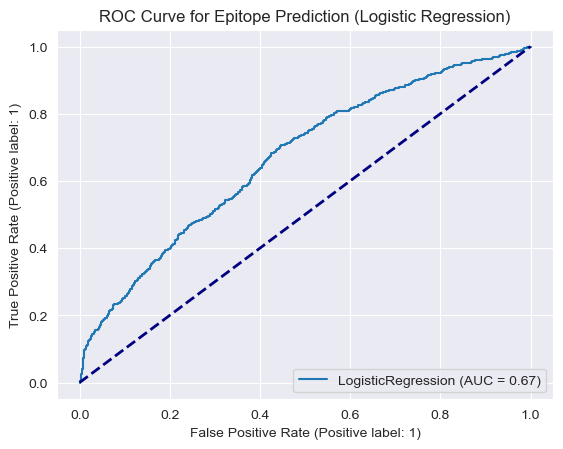

In [26]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logreg, X_validate, y_validate, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Epitope Prediction (Logistic Regression)')

In the plot above, we see the ROC Curve of our logistic regression. We see that it's above the dotted line, indicating that our model is doing better than just a random classifier in terms of the epitopes that it classifies. We can see this since our logistic regression is classifying more true positives than false positives. However, the area under the curve is not very high. This tells us that 

Now, we have our final logistic regression model. We have a macro average f1-score of 0.51 and a weighted average f1-score of 0.66. However, we are more concerned with the epitope class's f1-score since this is what we are trying to predict. Our model did not predict B-cell epitopes well as it only has an f1-score of 0.12 for the epitope class

We will now try and improve performance using other different types of models and see which will give the best outcome.

*****maybe play with decreasing or increasing threshold? to see if we can get better performance in terms of accurately selecting the epitope class

## K-Nearest Neighbors

We will now fit our data to a K-Nearest Neighbors classification model and asses its performance, comparing it to the base logistic regression model

Since we already have our final features and have defined our final train, validation, and test set from the Logistic Regression analysis above, we can start fitting our data to other models and asses its performance. 

Let's do a quick rundown on our final features. Our features include the four 'methods for epitope prediction' as well as the four parent protein characteristics. We have also added two important amino acids as well as the positionality and aromaticity of the peptides, within the whole protein sequence.

```
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr', 'start_position', 'aromaticity']
```

We will start by running this on a base KNN model with the default K-value of 5:

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# K-Nearest Neighbors
knn = KNeighborsClassifier().fit(X_train,y_train)
print_report(knn, X_train, y_train, X_validate, y_validate)

KNeighborsClassifier with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.839
Test score: 0.775
Confusion Matrix: 
 [[1508  122]
 [ 381  224]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1630
           1       0.65      0.37      0.47       605

    accuracy                           0.77      2235
   macro avg       0.72      0.65      0.66      2235
weighted avg       0.76      0.77      0.75      2235



Running our base KNN model, we see that the model is slightly overfitted. We also see a very high recall and precision on the non-epitope target class but still see a very poor performance on the epitopic class. The epitope class has a recall of 0.37 meaning that we are able to pick up on about 37% of the true positives, and a precision of 65% meaning that 65% of our predictions turned out to be true predictions.

We will try to improve this model by optimizing our K-value

### Optimal K-value:

Up until now, we have been running our models with the default K-value of 5. We will now explore different K-values in hopes of optimizing our K hyperparameter 

In [29]:
# create empty data frame for our results
knn_table = pd.DataFrame()

# loop through odd numbers and look for 
for n, k in enumerate(range(1,20)): # looking at odd numbers
    print(f'running through k-value = {k}', end="\r")
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    class_report_train = classification_report(y_train, knn.predict(X_train), output_dict=True)
    class_report = classification_report(y_validate, knn.predict(X_validate), output_dict=True)
    knn_table.loc[n, 'k-value'] = k
    knn_table.loc[n, 'Train score'] = knn.score(X_train, y_train)
    knn_table.loc[n, 'Validate score'] = knn.score(X_validate, y_validate)
    knn_table.loc[n, 'Validate Epitope precision'] = class_report['1']['precision']
    knn_table.loc[n, 'Validate Epitope recall'] = class_report['1']['recall']
    knn_table.loc[n, 'Validate Epitope f1'] = class_report['1']['f1-score']
    knn_table.loc[n, 'Train Epitope precision'] = class_report_train['1']['precision']
    knn_table.loc[n, 'Train Epitope recall'] = class_report_train['1']['recall']
    knn_table.loc[n, 'Train Epitope f1'] = class_report_train['1']['f1-score']

knn_table.set_index('k-value', inplace=True)
knn_table.head()

,Train score,Validate score,Validate Epitope precision,Validate Epitope recall,Validate Epitope f1,Train Epitope precision,Train Epitope recall,Train Epitope f1
k-value,,,,,,,,
1.0,1.000000,0.759284,0.567134,0.467769,0.512681,1.000000,1.000000,1.000000
2.0,0.866309,0.770470,0.712963,0.254545,0.375152,1.000000,0.506024,0.672000
3.0,0.876379,0.774049,0.625000,0.413223,0.497512,0.839309,0.671864,0.746310
4.0,0.832550,0.770917,0.704846,0.264463,0.384615,0.889855,0.435152,0.584484
5.0,0.838688,0.774944,0.647399,0.370248,0.471083,0.795337,0.543940,0.646044


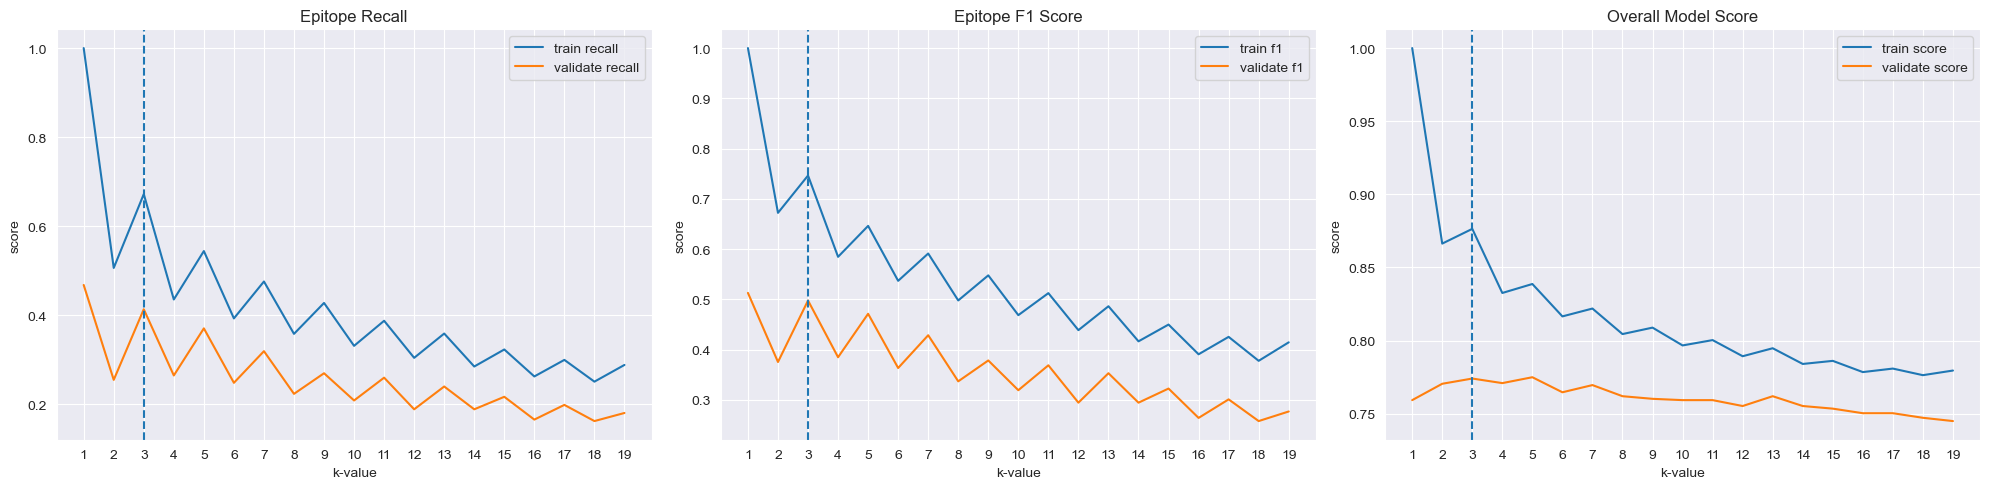

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].plot(knn_table.index, knn_table['Train Epitope recall'], label='train recall')
axes[0].plot(knn_table.index, knn_table['Validate Epitope recall'], label='validate recall')
axes[0].axvline(x=3, linestyle='--')
axes[0].set_xticks(range(1, 20))
axes[0].legend()
axes[0].set_title('Epitope Recall')
axes[0].set_xlabel('k-value')
axes[0].set_ylabel('score')

axes[1].plot(knn_table.index, knn_table['Train Epitope f1'], label='train f1')
axes[1].plot(knn_table.index, knn_table['Validate Epitope f1'], label='validate f1')
axes[1].axvline(x=3, linestyle='--')
axes[1].set_xticks(range(1, 20))
axes[1].legend()
axes[1].set_title('Epitope F1 Score')
axes[1].set_xlabel('k-value')
axes[1].set_ylabel('score')

axes[2].plot(knn_table.index, knn_table['Train score'], label='train score')
axes[2].plot(knn_table.index, knn_table['Validate score'], label='validate score')
axes[2].axvline(x=3, linestyle='--')
axes[2].set_xticks(range(1, 20))
axes[2].legend()
axes[2].set_title('Overall Model Score')
axes[2].set_xlabel('k-value')
axes[2].set_ylabel('score')

plt.tight_layout()
plt.show()



We actually see a very interesting pattern in the graphs above. Performance is drastically better when the k-value is an odd number as opposed to an even number. This is important to note because using an odd value for our K is actually very important and avoids confusion between the two target classes. Especially when the target is a binary variable.

Due to the context of our imbalanced target class, we are more interested in looking at the Epitope recall and f1-score. A k-value of 3 appears to give us the best performance. No matter which k-value we decide on, the model will not generalize well and will still end up overfitting. However, as we can see in the plots above, a k-value of 3 gives us better performance in terms of recall and f1-score while minimizing overfitting and performance loss.

In [31]:
# K-Nearest Neighbors with n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

# printing evaluation metrics
print_report(knn, X_train, y_train, X_validate, y_validate)

KNeighborsClassifier with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.876
Test score: 0.774
Confusion Matrix: 
 [[1480  150]
 [ 355  250]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85      1630
           1       0.62      0.41      0.50       605

    accuracy                           0.77      2235
   macro avg       0.72      0.66      0.68      2235
weighted avg       0.76      0.77      0.76      2235



In choosing a K-value of 3, we are able to increase the performance of our model on the validation set. We see that our recall for our epitopic class has increased to 41%, thus increasing our f1-score to 0.50. This is not a significant upgrade in terms of performance, but is still better than our previous models.

Text(0.5, 1.0, 'ROC Curve for Epitope Prediction (KNN)')

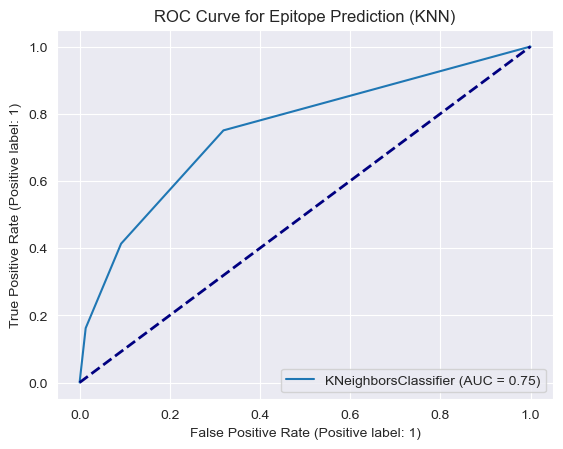

In [32]:
RocCurveDisplay.from_estimator(knn, X_validate, y_validate, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Epitope Prediction (KNN)')

In the above graph, we see that our model's confidence in telling a true positive increases compared to the logistic regression. We see an AUC of 0.75 and are able to tell true positives from false positives with more confidence.

## Support Vector Machines

Now, we will attempt to increase the performance of our predictive models by utilizing Support Vector Machines (SVMs). SVMs are another type of machine learning model that tries to find the middle boundary between the target classes. This is in a way similar to logistic regression but it also utilizes kernels. These kernels add non-linearity to our model and allows it to make decently accurate predictions. However, since the distribution of our features are very similar between our target classes, This style of modeling may not work. We will still try it out and test performance.

We will start with a base SVM with a linear kernel type

In [33]:
from sklearn.svm import SVC
# SVM with linear transformation
svm_linear = SVC(kernel='linear').fit(X_train, y_train)

# printing evaluation metrics
print_report(svm_linear, X_train, y_train, X_validate, y_validate)

SVC with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.729
Test score: 0.729
Confusion Matrix: 
 [[1630    0]
 [ 605    0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1630
           1       0.00      0.00      0.00       605

    accuracy                           0.73      2235
   macro avg       0.36      0.50      0.42      2235
weighted avg       0.53      0.73      0.62      2235



We see very terrible performance in our Linear SVM! We have a model that classifies everything as the negative, non-epitopic class! We see zero recall and f1-score for the epitopic class. This may be because our data is far from linear as we also saw poor performance from the logistic regression and we must introduce some non-linearity.

SVMs do have a kernel trick that we may be able to utilize different kernels to introduce different types of non-linearity to our model in an attempt to improve performance. We will now try a radial basis kernel and evaluate its performance on our validation dataset

In [34]:
from sklearn.svm import SVC
# SVM with rbf transformation
svm_rbf = SVC(kernel='rbf').fit(X_train, y_train)

# printing evaluation metrics
print_report(svm_rbf, X_train, y_train, X_validate, y_validate)

SVC with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.764
Test score: 0.751
Confusion Matrix: 
 [[1604   26]
 [ 530   75]]
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1630
           1       0.74      0.12      0.21       605

    accuracy                           0.75      2235
   macro avg       0.75      0.55      0.53      2235
weighted avg       0.75      0.75      0.68      2235



We see a slightly better, but still very poor performance with the radial basis function transformation. We see a recall score of 0.12 for the positive class and a f1-score of 0.21. This is by no means a good sight to see and we must test more kernels to see if any would have a better result.

Next, we will try a polynomial kernel.

In [35]:
# SVM with polynomial transformation
svm_poly = SVC(kernel='poly').fit(X_train, y_train)

# printing evaluation metrics
print_report(svm_poly, X_train, y_train, X_validate, y_validate)

SVC with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.75
Test score: 0.741
Confusion Matrix: 
 [[1613   17]
 [ 562   43]]
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1630
           1       0.72      0.07      0.13       605

    accuracy                           0.74      2235
   macro avg       0.73      0.53      0.49      2235
weighted avg       0.73      0.74      0.65      2235



The classification report above tells us that a polynomial kernel shows a worse performance than a radial basis function kernel. We will now try the sigmoid transformation.

In [36]:
# SVM with sigmoid transformation
svm_sig = SVC(kernel='sigmoid').fit(X_train, y_train)

# printing evaluation metrics
print_report(svm_sig, X_train, y_train, X_validate, y_validate)

SVC with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.609
Test score: 0.605
Confusion Matrix: 
 [[1175  455]
 [ 428  177]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1630
           1       0.28      0.29      0.29       605

    accuracy                           0.60      2235
   macro avg       0.51      0.51      0.51      2235
weighted avg       0.61      0.60      0.61      2235



A sigmoid kernel increases our recall for the positive class but also greatly decreases our overall accuracy! The sigmoid kernel SVM classifies a great amount of false positives, but is also able to classify some true positives. In our case we want a good balance of precision and recall of the epitopic class. Therefore, it seems like the sigmoid kernel is the best for our data, considering it shows the highest f1-score, even if there are many false positives.

Next, we will attempt to tune our C-value to get an even higher result.

In [37]:
scores = pd.DataFrame()
c_range = [10 ** exp for exp in range(-5, 5 + 1, 1)]

for n,i in enumerate(c_range):
    svm_sig = SVC(kernel='sigmoid', C=i)
    svm_sig.fit(X_train, y_train)
    class_report_train = classification_report(y_train, svm_sig.predict(X_train), output_dict=True)
    class_report_val = classification_report(y_validate, svm_sig.predict(X_validate), output_dict=True)

    # appending values and metrics to our scores table
    scores.loc[n,'C-value'] = i
    scores.loc[n,'Training f1 (1)'] = class_report_train['1']['f1-score'] 
    scores.loc[n,'Validation f1 (1)'] = class_report_val['1']['f1-score'] 
scores

,C-value,Training f1 (1),Validation f1 (1)
0,0.00001,0.000000,0.000000
1,0.00010,0.000000,0.000000
2,0.00100,0.000000,0.000000
3,0.01000,0.008032,0.006098
4,0.10000,0.237470,0.250454
5,1.00000,0.270338,0.286176
6,10.00000,0.275483,0.286174
7,100.00000,0.276803,0.284337
8,1000.00000,0.276803,0.285485
9,10000.00000,0.276449,0.285485


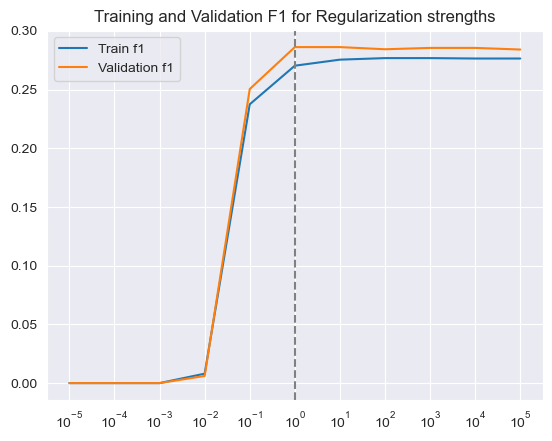

In [38]:
# creating visual to compare train and validation accuracies across different regularization strengths
plt.figure()
plt.plot(scores['C-value'], scores['Training f1 (1)'], label='Train f1')
plt.plot(scores['C-value'], scores['Validation f1 (1)'], label='Validation f1')
plt.title('Training and Validation F1 for Regularization strengths')
plt.xlabel
plt.legend()
plt.xscale('log')
plt.axvline(x=10e-1, linestyle='--', c='grey')
plt.xticks(c_range)
plt.show()

Seen in the graph above, we have chosen to stick with the default C-value of 1, since it gives us the highest F1-score on our validation set. This will be our final SVM model and we will now take a look at the ROC curve to see how well the model is able to predict true positives

Text(0.5, 1.0, 'ROC Curve for Epitope Prediction (SVM with Sigmoid Kernel)')

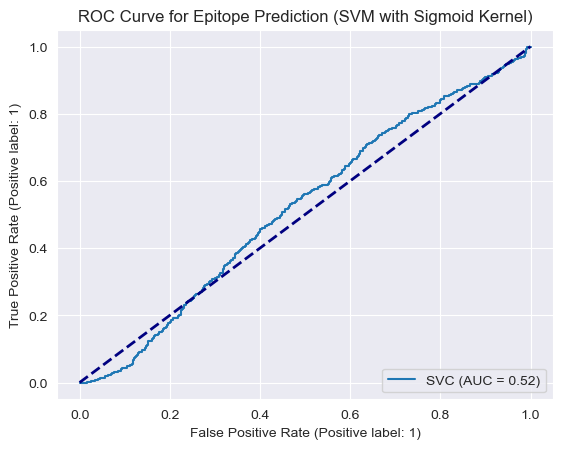

In [39]:
# showing roc curve for sigmoid kernel
RocCurveDisplay.from_estimator(svm_sig, X_validate, y_validate, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Epitope Prediction (SVM with Sigmoid Kernel)')

Oh man, just like what we saw above, the ROC curve does not look good. We see an area under the curve of about 0.52 and even some points of the ROC curve dipping underneath the middle line. We saw this in the classification report above as the model was predicting many false positives.

From what we have seen, a SVM is not ideal for our problem space and our data. We will look towards other types of models to get a good performance.

## Random Forest

Next, we will attempt to improve the performance through ensemble learning. We will do this through a random forest model. This is an ensemble of decision trees. Many different decision trees are trained on different subsets of the data and the outputs of multiple decision trees are combined to reach a single result. We will start with 5 estimators and an unlimited max depth as a base model

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
# instantiate random forest model with 5 estimators
rfc = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)

#print evaluation metrics
print_report(rfc, X_train, y_train, X_validate, y_validate)

RandomForestClassifier with features: ['chou_fasman' 'emini' 'kolaskar_tongaonkar' 'parker'
 'parent_hydrophobicity' 'parent_isoelectric_point' 'parent_aromaticity'
 'parent_instability_index' 'amino_acid_pro' 'amino_acid_tyr'
 'start_position' 'aromaticity']
Training score: 0.979
Test score: 0.837
Confusion Matrix: 
 [[1489  141]
 [ 224  381]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1630
           1       0.73      0.63      0.68       605

    accuracy                           0.84      2235
   macro avg       0.80      0.77      0.78      2235
weighted avg       0.83      0.84      0.83      2235



Wow!! This base ensemble method already gives us very good accuracy on our validation set! We also see that the precision, recall and f1-score for the positive class is significantly better than any of the other past models that we have ran. However, since we did not set a limit on the max depth of the trees, we see great overfitting in the model.

Next, we will see what the best range of estimators would be to give us the best performance.

In [42]:
scores = pd.DataFrame()

for n,i in enumerate(range(5,200,5)):
    rfc = RandomForestClassifier(n_estimators=i, random_state=0)
    rfc.fit(X_train, y_train)
    class_report_train = classification_report(y_train, rfc.predict(X_train), output_dict=True)
    class_report_val = classification_report(y_validate, rfc.predict(X_validate), output_dict=True)

    # appending values and metrics to our scores table
    scores.loc[n,'estimators'] = i
    scores.loc[n,'Training f1 (1)'] = class_report_train['1']['f1-score'] 
    scores.loc[n,'Validation f1 (1)'] = class_report_val['1']['f1-score'] 
scores.head()

,estimators,Training f1 (1),Validation f1 (1)
0,5.0,0.959943,0.676131
1,10.0,0.977617,0.653295
2,15.0,0.990920,0.677716
3,20.0,0.993047,0.674136
4,25.0,0.997337,0.692168


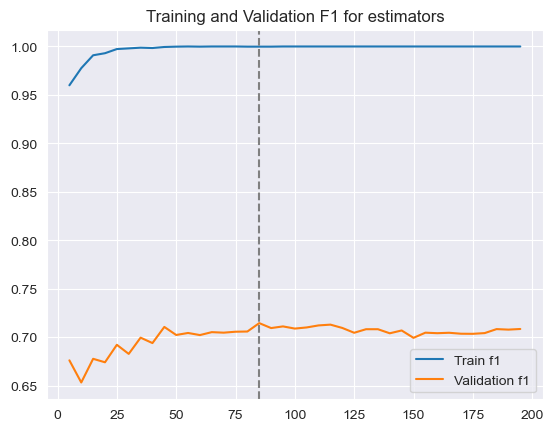

In [43]:
# creating visual to compare train and validation accuracies across different numbers of extimators
plt.figure()
plt.plot(scores['estimators'], scores['Training f1 (1)'], label='Train f1')
plt.plot(scores['estimators'], scores['Validation f1 (1)'], label='Validation f1')
plt.title('Training and Validation F1 for estimators')
plt.xlabel
plt.axvline(x=85, linestyle='--', c='grey')
plt.legend()
plt.show()

From the graph above, we see that we are able to get the best f1-score out of our model possibly between the estimator ranges of 80-100. We will set the n_estimators at 85 for now while we tune the best max_depth for our model to minimize overfitting.

In [44]:
scores = pd.DataFrame()

for n,i in enumerate(range(2,30,2)):
    rfc = RandomForestClassifier(n_estimators=85, max_depth=i, random_state=0)
    rfc.fit(X_train, y_train)
    class_report_train = classification_report(y_train, rfc.predict(X_train), output_dict=True)
    class_report_val = classification_report(y_validate, rfc.predict(X_validate), output_dict=True)

    # appending values and metrics to our scores table
    scores.loc[n,'max_depth'] = i
    scores.loc[n,'Training f1 (1)'] = class_report_train['1']['f1-score'] 
    scores.loc[n,'Validation f1 (1)'] = class_report_val['1']['f1-score'] 
scores.head()

,max_depth,Training f1 (1),Validation f1 (1)
0,2.0,0.000000,0.000000
1,4.0,0.099429,0.102326
2,6.0,0.408252,0.338501
3,8.0,0.615777,0.492027
4,10.0,0.756722,0.590576


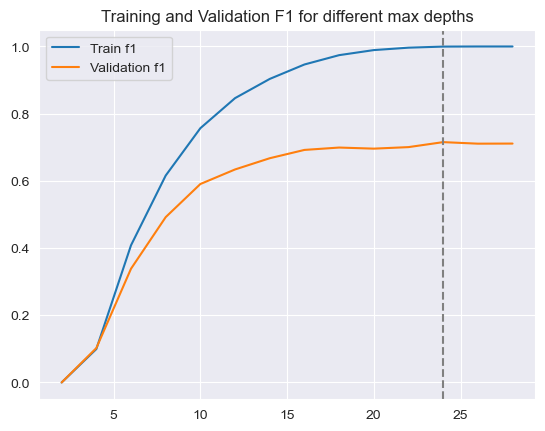

In [45]:
# creating visual to compare train and validation accuracies across different max depths
plt.figure()
plt.plot(scores['max_depth'], scores['Training f1 (1)'], label='Train f1')
plt.plot(scores['max_depth'], scores['Validation f1 (1)'], label='Validation f1')
plt.title('Training and Validation F1 for different max depths')
plt.xlabel
plt.axvline(x=24, linestyle='--', c='grey')
plt.legend()
plt.show()

As we can see with the graph above, we know that the best max_depth would lie between a value of 20 and 25. We can take this information and combine it with the info we have on the best number of estimators and run a grid search. This grid search will use cross-validation to find out which of the hyperparameter values would give us the best model possible:

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# create gridsearch pipeline for max_depth between 20 and 25 and n_estimators between 80 and 90
pipe = Pipeline([('scaler', StandardScaler()),
                 ('classifier' , RandomForestClassifier())])

param_grid = [{'classifier__max_depth' : range(20,25,1),
              'classifier__n_estimators' : range(80,90,1)}]

# create gridsearch object
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# fit on the combined training and validation sets
best_model = grid.fit(X_combined, y_combined)

# print best parameters
print(best_model.best_estimator_.get_params()['classifier'])



Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomForestClassifier(max_depth=22, n_estimators=86)


As we can see above, the grid search found that a max_depth of 22 and 86 estimators would give us the best performance overall. We can now run this model one more time and look at it's performance

In [123]:
# random forest classifier with 86 estimators and max depth of 22
rfc = RandomForestClassifier(n_estimators=86, max_depth=22, random_state=0).fit(X_train, y_train)

# print evaluation metrics
print_report(rfc, X_train, y_train, X_validate, y_validate)

RandomForestClassifier:
Training score: 0.998
Validation score: 0.854 

Confusion Matrix: 
 [[1530  100]
 [ 227  378]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1630
           1       0.79      0.62      0.70       605

    accuracy                           0.85      2235
   macro avg       0.83      0.78      0.80      2235
weighted avg       0.85      0.85      0.85      2235



We see that our final random forest classifier gives us a recall of 62% and a f1-score of 0.70 on the epitopic class. This is our best model so far and is able to pick up on 62% of the true positives in our dataset. We know that this is likely the best generalized model since the grid search uses cross-validation to evaluate performance of each model and to tune the hyperparameters. In cross-validation, the data are split into different subsets called "folds" and the model is trained many times, each fold acting as the validation set for each runthrough while the remaining folds are used as the test set. The cross-validation score is then calculated as the mean of each train-validation score. The grid search uses this to tune each set hyperparameter and therefore we know that This may show us the best performance in the real world.

Now we will have a look at the ROC curve of our final random forest classifier

Text(0.5, 1.0, 'ROC Curve for Epitope Prediction (Random Forest Classifier)')

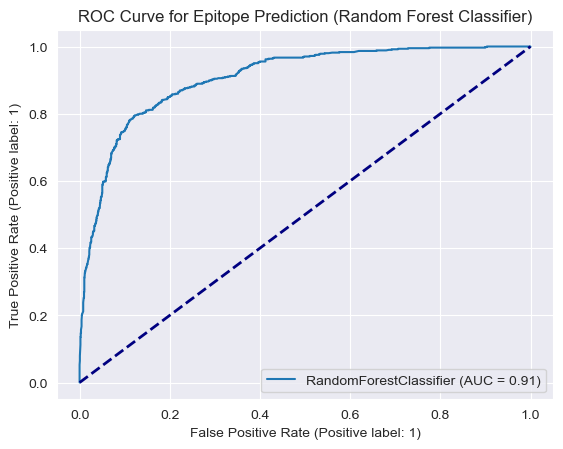

In [124]:
# showing roc curve for random forest classifier
RocCurveDisplay.from_estimator(rfc, X_validate, y_validate, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Epitope Prediction (Random Forest Classifier)')

## Boosting

Another Ensemble method that we can explore would be that of boosting. There are two types of boosting, Adaptive boosting and Gradient boosting. We will first start with Adaptive boosting:

### Adaptive boosting:

Adaptive boosting is when we fit a sequence of weak models, each model trained on the error of the previous model. Here, we will start by training an AdaBoost with 50 one-stump decision trees and assess it's performance

In [90]:
from sklearn.ensemble import AdaBoostClassifier

# instantiate adaboost classifier with 1 estimator
ada = AdaBoostClassifier(n_estimators=50, random_state=0).fit(X_train, y_train)

# print evaluation metrics
print_report(ada, X_train, y_train, X_validate, y_validate)

AdaBoostClassifier:
Training score: 0.774
Test score: 0.774 

Confusion Matrix: 
 [[1520  110]
 [ 396  209]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.79      0.93      0.86      1630
           1       0.66      0.35      0.45       605

    accuracy                           0.77      2235
   macro avg       0.72      0.64      0.65      2235
weighted avg       0.76      0.77      0.75      2235



Wow! our base AdaBoost model performed much better than many of our other models. With 50 estimators, we see a 0.45 in our f1-score. This is by no means a good model, but it is still much better than the majority of models we have made above. We will attempt to increase this performance by looping through many different estimator values to see which hyperparameter value will give our model the best performance

In [96]:
# create empty dataframe to store scores
scores = pd.DataFrame()

# loop through different numbers of estimators 
for n,i in enumerate(range(100,2100,100)):
    # printing progress
    print('Fitting model {} of {}'.format(n+1, len(range(100,2100,100))), end='\r')
    ada = AdaBoostClassifier(n_estimators=i, random_state=0)
    ada.fit(X_train, y_train)
    class_report_train = classification_report(y_train, ada.predict(X_train), output_dict=True)
    class_report_val = classification_report(y_validate, ada.predict(X_validate), output_dict=True)

    # appending values and metrics to our scores table
    scores.loc[n,'estimators'] = i
    scores.loc[n,'Training f1 (1)'] = class_report_train['1']['f1-score'] 
    scores.loc[n,'Validation f1 (1)'] = class_report_val['1']['f1-score']

scores.head()

,estimators,Training f1 (1),Validation f1 (1)
0,100.0,0.522732,0.484211
1,200.0,0.581655,0.516461
2,300.0,0.600801,0.545639
3,400.0,0.618535,0.566301
4,500.0,0.635141,0.566038


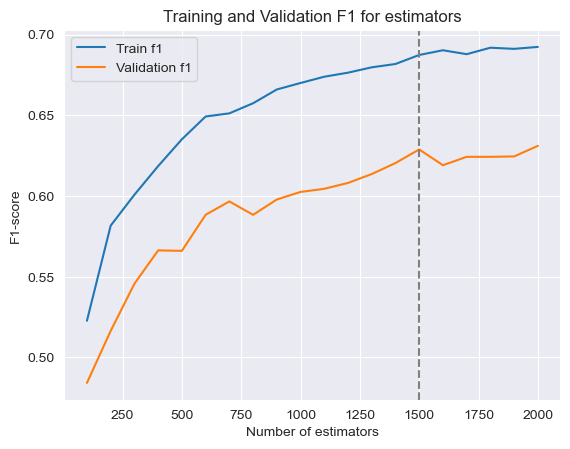

In [98]:
# creating plot comparing train and validation f1-scores across different numbers of extimators
plt.figure()
plt.plot(scores['estimators'], scores['Training f1 (1)'], label='Train f1')
plt.plot(scores['estimators'], scores['Validation f1 (1)'], label='Validation f1')
plt.title('Training and Validation F1 for estimators')
plt.xlabel('Number of estimators')
plt.ylabel('F1-score')
plt.axvline(x=1500, linestyle='--', c='grey')
plt.legend()
plt.show()

In the plot above, we see that the best number of estimators may lie around the 1500 area. We will now loop every from 1300 to 1600 in steps of 20 to see if we can narrow it down a bit more

In [100]:
scores = pd.DataFrame()

# loop through different estimators from 1300 to 1600 in steps of 20
for n,i in enumerate(range(1300,1620,20)):
    # printing progress
    print('Fitting model {} of {}'.format(n+1, len(range(1300,1600,20))), end='\r')
    ada = AdaBoostClassifier(n_estimators=i, random_state=0)
    ada.fit(X_train, y_train)
    class_report_train = classification_report(y_train, ada.predict(X_train), output_dict=True)
    class_report_val = classification_report(y_validate, ada.predict(X_validate), output_dict=True)

    # appending values and metrics to our scores table
    scores.loc[n,'estimators'] = i
    scores.loc[n,'Training f1 (1)'] = class_report_train['1']['f1-score'] 
    scores.loc[n,'Validation f1 (1)'] = class_report_val['1']['f1-score']

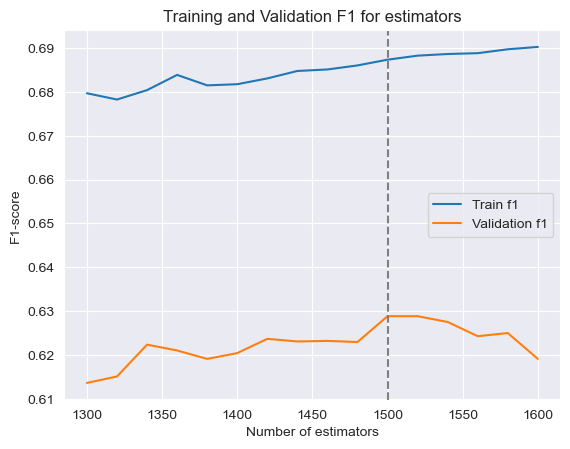

In [101]:
# creating plot comparing train and validation f1-scores across different numbers of extimators
plt.figure()
plt.plot(scores['estimators'], scores['Training f1 (1)'], label='Train f1')
plt.plot(scores['estimators'], scores['Validation f1 (1)'], label='Validation f1')
plt.title('Training and Validation F1 for estimators')
plt.xlabel('Number of estimators')
plt.ylabel('F1-score')
plt.axvline(x=1500, linestyle='--', c='grey')
plt.legend()
plt.show()

In [104]:
from sklearn.metrics import make_scorer, f1_score
# grid search for best learning rate and estimators to optimize f1-score for class 1
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('classifier', AdaBoostClassifier())])

param_grid = [{'classifier__n_estimators' : range(1500,1520),
               'classifier__learning_rate' : [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]}]

grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring=make_scorer(f1_score, pos_label=1))

# fit on the combined training and validation sets
best_model = grid.fit(X_combined, y_combined)

# print best parameters
print(best_model.best_estimator_.get_params()['classifier'])



Fitting 5 folds for each of 140 candidates, totalling 700 fits
AdaBoostClassifier(learning_rate=1.75, n_estimators=1519)


After running the grid search, we see that a learning rate of 1.75 and 1519 estimators are the best hyperparameter values for our AdaBoost model. We will run this final model one more time and check it's performance on predicting the positive target class

In [105]:
# adaboost with 1519 estimators and learning rate of 1.75
ada = AdaBoostClassifier(n_estimators=1519, learning_rate=1.75, random_state=0).fit(X_train, y_train)

# print evaluation metrics
print_report(ada, X_train, y_train, X_validate, y_validate)

AdaBoostClassifier:
Training score: 0.865
Test score: 0.826 

Confusion Matrix: 
 [[1514  116]
 [ 274  331]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1630
           1       0.74      0.55      0.63       605

    accuracy                           0.83      2235
   macro avg       0.79      0.74      0.76      2235
weighted avg       0.82      0.83      0.82      2235



In our final AdaBoost model, we see that the validation score is not much lower than the train score. This means that the model is not overfitting as much as the Random Forest model. We also see a 55% recall and a f1-score of 0.63. This is on the higher end of all our models, but still not better than the Random forest.

Below will be the ROC curve

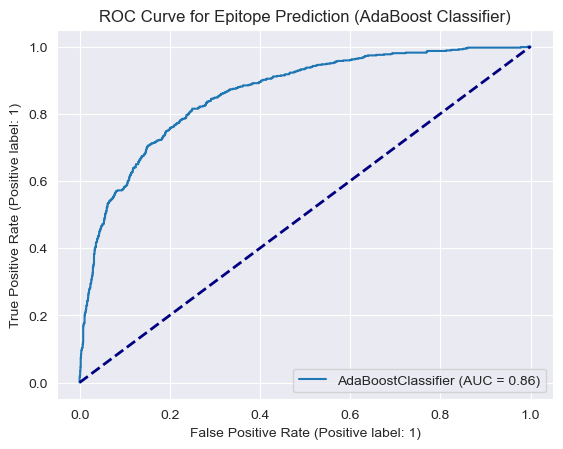

In [125]:
# showing roc curve for adaboost classifier
RocCurveDisplay.from_estimator(ada, X_validate, y_validate, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Epitope Prediction (AdaBoost Classifier)')
plt.show()

### Gradient boosting

Built on the techniques of AdaBoosting, gradient boosting will fit each sub-model with the residuals of the previous models. For our gradient boosting model, we will use XGBoost

In [162]:
from xgboost import XGBClassifier

# instantiate xgboost classifier
xgb = XGBClassifier(random_state=0).fit(X_train, y_train)

# print evaluation metrics
print_report(xgb, X_train, y_train, X_validate, y_validate)

XGBClassifier:
Training score: 0.953
Validation score: 0.848 

Confusion Matrix: 
 [[1523  107]
 [ 233  372]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1630
           1       0.78      0.61      0.69       605

    accuracy                           0.85      2235
   macro avg       0.82      0.77      0.79      2235
weighted avg       0.84      0.85      0.84      2235



The base XGBoost shows performance similar to the random forest model. We see a recall of 61% and an f1-score of 0.69. However, we can also run a grid search to search through the best parameters for this model:

In [167]:
# grid search for best learning rate, gamma, estimators, and regularization to optimize f1-score for class 1
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('classifier', XGBClassifier(random_state=0))])

param_grid = [{'classifier__gamma': [0, 0.1, 0.5, 1],
               'classifier__learning_rate': [0.01, 0.5, 1, 1.5],
               'classifier__n_estimators': [50, 100, 150],
               'classifier__reg_alpha': [0, 0.01, 0.1, 1],
               'classifier__reg_lambda': [0, 0.01, 0.1, 1]}]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1, scoring=make_scorer(f1_score, pos_label=1))

# fit on the combined training and validation sets
best_model = grid.fit(X_combined, y_combined)

# print best parameters
print(best_model.best_estimator_.get_params()['classifier'])


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


In [180]:
# printing best parameters
print(best_model.best_params_)

{'classifier__gamma': 0.1, 'classifier__learning_rate': 0.5, 'classifier__n_estimators': 150, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 0}


The grid search gives us our optimal parameters, evaluated through cross-validation. The parameters are as follows:

Optimal Parameters:
* Gamma: 0.1
* Learning Rate: 0.5
* Estimators: 150
* Alpha Regularization: 1
* Lambda Regularization: 0

We will now set these parameters up in a final XGBoost Classifier and assess it's performance:

In [184]:
# xgboost with best parameters
xgb = XGBClassifier(gamma=0.1, learning_rate=0.5, n_estimators=150, reg_alpha=1, reg_lambda=0, random_state=0).fit(X_train, y_train)

# print evaluation metrics
print_report(xgb, X_train, y_train, X_validate, y_validate)

XGBClassifier:
Training score: 0.999
Validation score: 0.856 

Confusion Matrix: 
 [[1515  115]
 [ 207  398]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      1630
           1       0.78      0.66      0.71       605

    accuracy                           0.86      2235
   macro avg       0.83      0.79      0.81      2235
weighted avg       0.85      0.86      0.85      2235



This is our final XGBoost model. We see that both the recall and f1-score has increased to higher than the random forest classifier. We see a 66% recall for the epitopic class and an f1-score of 71. We can take a look at the ROC curve now

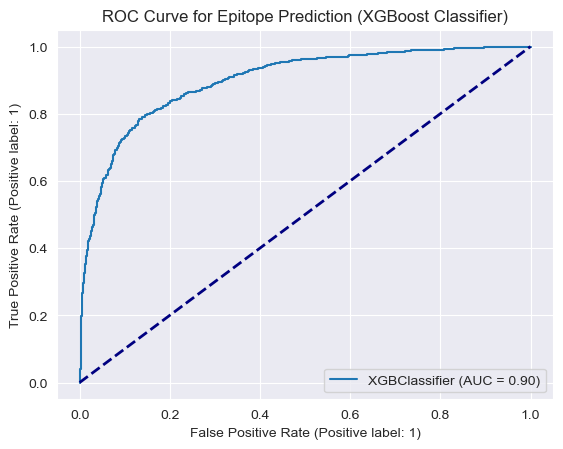

In [192]:
# showing roc curve for xgboost classifier
RocCurveDisplay.from_estimator(xgb, X_validate, y_validate, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Epitope Prediction (XGBoost Classifier)')
plt.show()

Wow! The ROC curve above shows that the tuned XGBoost model is able to predict epitopes decently well. The area under the curve is 0.90 which is the highest of all our models. This will be our final XGBoost model and our highest performing model overall.

we can now build a pipeline for this final model and test its accuracy on our test set.

In [196]:
import joblib

# pipeline for XGBoost classifier
xgb_pipe = Pipeline([('scaler', StandardScaler()), 
                 ('classifier', XGBClassifier(gamma=0.1, learning_rate=0.5, n_estimators=150, reg_alpha=1, reg_lambda=0, random_state=0))])

# fitting pipeline on combined training and validation sets
xgb_pipe.fit(X_combined, y_combined)

# saving pipeline
joblib.dump(xgb_pipe, 'xgb_pipeline.pkl')

# loading pipeline
xgb_pipe = joblib.load('xgb_pipeline.pkl')

# printing evaluation metrics for test set
print_report(xgb_pipe, X_combined, y_combined, X_test, y_test)


Pipeline:
Training score: 0.998
Validation score: 0.84 

Confusion Matrix: 
 [[1491  138]
 [ 220  385]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      1629
           1       0.74      0.64      0.68       605

    accuracy                           0.84      2234
   macro avg       0.80      0.78      0.79      2234
weighted avg       0.83      0.84      0.84      2234



## Training on only Bcell data and testing on SARS

To really put our model to the test and see if it will pick up on general epitope patterns as well and test for true overfitting, we will fit our final XGBoost model on the general bcell data and test it on the proteins specific to the SARS organism.

In [202]:
bcell = pd.read_csv('bcell_cleaned.csv')
sars = pd.read_csv('sars_cleaned.csv')

X_bcell = bcell[features]
y_bcell = bcell['antibody_activity']

X_sars = sars[features]
y_sars = sars['antibody_activity']

xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('classifier', XGBClassifier(gamma=0.1, learning_rate=0.5, n_estimators=150, reg_alpha=1, reg_lambda=0, random_state=0))])

xgb_pipe.fit(X_bcell, y_bcell)

print_report(xgb_pipe, X_bcell, y_bcell, X_sars, y_sars)

Pipeline:
Training score: 0.996
Validation score: 0.613 

Confusion Matrix: 
 [[259 121]
 [ 78  56]]

Classification report for validation set: 
               precision    recall  f1-score   support

           0       0.77      0.68      0.72       380
           1       0.32      0.42      0.36       134

    accuracy                           0.61       514
   macro avg       0.54      0.55      0.54       514
weighted avg       0.65      0.61      0.63       514



Interestingly, we see a big drop in model performance when training on the B-cell dataset and testing on the SARS dataset. This tells us that every organism may have their own specific patterns and it is very difficult to predict new epitopes from never before seen organism and diseases. We would likely need to include the context of the whole protein sequence as well as the peptide sequences to be able to predict epitopes from never before seen organisms and viruses.

## Conclusion
d
